In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
from torch.autograd import Variable
import torch.distributions as dist
from tqdm.notebook import tqdm

In [2]:
%config InlineBackend.figure_format = "retina"
sns.set()

In [3]:
import math
from numbers import Number

import torch
from torch.distributions import Distribution, constraints
from torch.distributions.utils import broadcast_all

CONST_SQRT_2 = math.sqrt(2)
CONST_INV_SQRT_2PI = 1 / math.sqrt(2 * math.pi)
CONST_INV_SQRT_2 = 1 / math.sqrt(2)
CONST_LOG_INV_SQRT_2PI = math.log(CONST_INV_SQRT_2PI)
CONST_LOG_SQRT_2PI_E = 0.5 * math.log(2 * math.pi * math.e)


class TruncatedStandardNormal(Distribution):
    """
    Truncated Standard Normal distribution
    https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    """

    arg_constraints = {
        'a': constraints.real,
        'b': constraints.real,
    }
    support = constraints.real
    has_rsample = True

    def __init__(self, a, b, eps=1e-8, validate_args=None):
        self.a, self.b = broadcast_all(a, b)
        if isinstance(a, Number) and isinstance(b, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.a.size()
        super(TruncatedStandardNormal, self).__init__(batch_shape, validate_args=validate_args)
        if self.a.dtype != self.b.dtype:
            raise ValueError('Truncation bounds types are different')
        if any((self.a >= self.b).view(-1,).tolist()):
            raise ValueError('Incorrect truncation range')
        self._dtype_min_gt_0 = torch.tensor(torch.finfo(self.a.dtype).eps, dtype=self.a.dtype)
        self._dtype_max_lt_1 = torch.tensor(1 - torch.finfo(self.a.dtype).eps, dtype=self.a.dtype)
        self._little_phi_a = self._little_phi(self.a)
        self._little_phi_b = self._little_phi(self.b)
        self._big_phi_a = self._big_phi(self.a)
        self._big_phi_b = self._big_phi(self.b)
        self._Z = (self._big_phi_b - self._big_phi_a).clamp_min(eps)
        self._log_Z = self._Z.log()
        self._lpbb_m_lpaa_d_Z = (self._little_phi_b * self.b - self._little_phi_a * self.a) / self._Z
        self._mean = -(self._little_phi_b - self._little_phi_a) / self._Z
        self._variance = 1 - self._lpbb_m_lpaa_d_Z - ((self._little_phi_b - self._little_phi_a) / self._Z) ** 2
        self._entropy = CONST_LOG_SQRT_2PI_E + self._log_Z - 0.5 * self._lpbb_m_lpaa_d_Z

    @property
    def mean(self):
        return self._mean

    @property
    def variance(self):
        return self._variance

    @property
    def entropy(self):
        return self._entropy

    @property
    def auc(self):
        return self._Z

    @staticmethod
    def _little_phi(x):
        return (-(x ** 2) * 0.5).exp() * CONST_INV_SQRT_2PI

    @staticmethod
    def _big_phi(x):
        return 0.5 * (1 + (x * CONST_INV_SQRT_2).erf())

    @staticmethod
    def _inv_big_phi(x):
        return CONST_SQRT_2 * (2 * x - 1).erfinv()

    def cdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return ((self._big_phi(value) - self._big_phi_a) / self._Z).clamp(0, 1)

    def icdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return self._inv_big_phi(self._big_phi_a + value * self._Z)

    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return CONST_LOG_INV_SQRT_2PI - self._log_Z - (value ** 2) * 0.5

    def rsample(self, sample_shape=torch.Size()):
        shape = self._extended_shape(sample_shape)
        p = torch.empty(shape).uniform_(self._dtype_min_gt_0, self._dtype_max_lt_1)
        return self.icdf(p)

    def expand(self, batch_shape, _instance=None):
        # TODO: it is likely that keeping temporary variables in private attributes violates the logic of this method
        raise NotImplementedError


class TruncatedNormal(TruncatedStandardNormal):
    """
    Truncated Normal distribution
    https://people.sc.fsu.edu/~jburkardt/presentations/truncated_normal.pdf
    """

    arg_constraints = {
        'loc': constraints.real,
        'scale': constraints.positive,
        'a': constraints.real,
        'b': constraints.real,
    }
    support = constraints.real
    has_rsample = True

    def __init__(self, loc, scale, a, b, eps=1e-8, validate_args=None):
        self.loc, self.scale, self.a, self.b = broadcast_all(loc, scale, a, b)
        a_standard = (a - self.loc) / self.scale
        b_standard = (b - self.loc) / self.scale
        super(TruncatedNormal, self).__init__(a_standard, b_standard, eps=eps, validate_args=validate_args)
        self._log_scale = self.scale.log()
        self._mean = self._mean * self.scale + self.loc
        self._variance = self._variance * self.scale ** 2
        self._entropy += self._log_scale

    def _to_std_rv(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return (value - self.loc) / self.scale

    def _from_std_rv(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return value * self.scale + self.loc

    def cdf(self, value):
        return super(TruncatedNormal, self).cdf(self._to_std_rv(value))

    def icdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return self._from_std_rv(super(TruncatedNormal, self).icdf(value))

    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return super(TruncatedNormal, self).log_prob(self._to_std_rv(value)) - self._log_scale

# Generate data

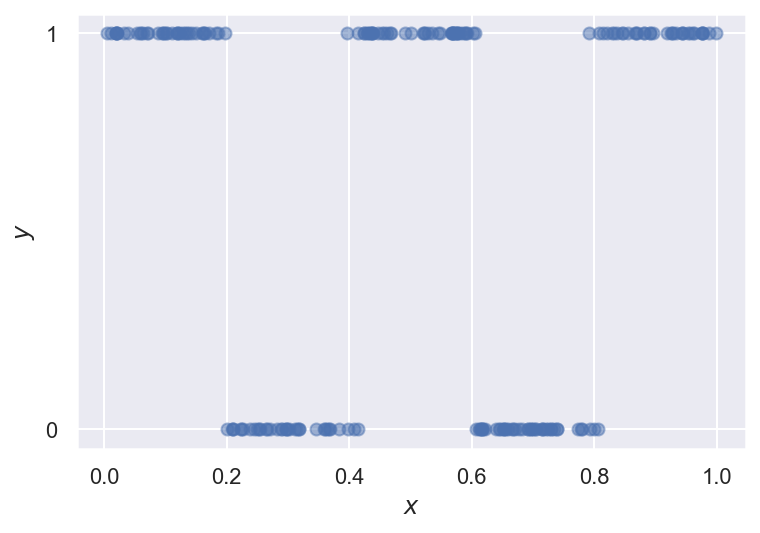

In [4]:
np.random.seed(0)

def true_f(x):
    return np.sin(10*x * np.pi * 0.5) * 10

n = 200
x = np.sort(np.random.uniform(0, 1, n))
f = true_f(x)
y = scipy.stats.bernoulli.rvs(scipy.special.expit(f))

plt.scatter(x, y, alpha=0.5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.yticks([0, 1]);

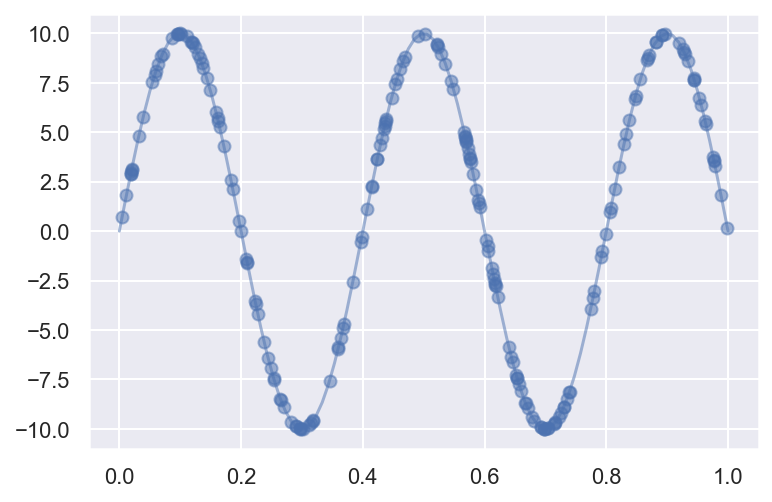

In [5]:
fig, ax = plt.subplots()
x_plot = np.linspace(0, 1, 100)
ax.plot(x_plot, true_f(x_plot), alpha=0.5)
ax.scatter(x, f, alpha=0.5);

In [6]:
train_x = torch.from_numpy(x.astype(np.float32))
train_y = torch.from_numpy(y.astype(np.float32))
print(train_x.dtype)
print(train_y.dtype)

torch.float32
torch.float32


In [7]:
def kernel(X, Xs, length):
    deltaX = torch.pow((X[:, None] - Xs) / length, 2.0)
    return torch.exp(-0.5 * deltaX)

In [17]:
class Model(torch.nn.Module):
    
    def __init__(self, jitter=1e-02):
        
        super().__init__()
        
        self.unc_var = torch.nn.Parameter(torch.zeros(1))
        self.unc_length = torch.nn.Parameter(torch.zeros(1))
        self.eta = torch.nn.Parameter(torch.zeros(len(x)))
        self.jitter = jitter
        
        self.softplus = torch.nn.Softplus()
    
    def var(self):
        return self.softplus(self.unc_var)
    
    def length(self):
        return self.softplus(self.unc_length)
    
    def loss(self, X, y):
        
        var = self.var()
        length = self.length()
        
        eta = self.eta
        
        K = var**2 * kernel(X, X, length) + self.jitter * torch.eye(X.size(0))
        L = torch.linalg.cholesky(K)
        f = L@eta
        
        return - dist.Bernoulli(logits=f).log_prob(y).sum() \
            - dist.Normal(loc=0., scale=1.).log_prob(eta).sum() \
            - TruncatedNormal(loc=0, scale=1, a=0, b=np.inf).log_prob(var).sum() \
            - TruncatedNormal(loc=1, scale=1, a=0, b=np.inf).log_prob(length).sum()
    
    def forward(self, X):
        
        var = self.var()
        length = self.length()
        
        eta = self.eta
        
        K = var**2 * kernel(X, X, length) + self.jitter * torch.eye(X.size(0))
        L = torch.linalg.cholesky(K)
        
        f = L@eta
        
        f_var = torch.diag(K)
        f_std = torch.sqrt(f_var)
        return f, f_std

In [18]:
model = Model()

epochs = 1000 

optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

iterator = tqdm(range(epochs))

for i in iterator:
    
    optimizer.zero_grad()
    loss = model.loss(train_x, train_y)
    loss.backward()
    
    optimizer.step()
    
    iterator.set_postfix(loss=loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

In [19]:
f_pred, f_std = model(train_x)

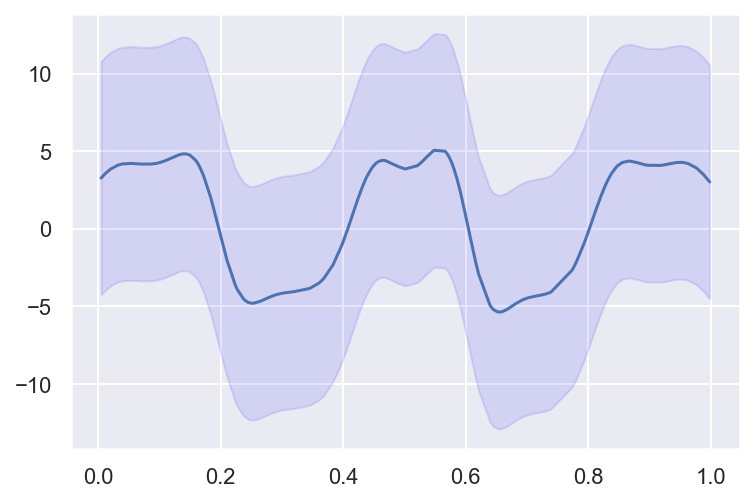

In [20]:
fig, ax = plt.subplots() 
ax.plot(train_x.data, f_pred.data)
ax.fill_between(train_x.data, 
                 f_pred.data + 1.96 * f_std.data, 
                 f_pred.data - 1.96 * f_std.data,
                 color='blue', alpha=0.1)

# Discrepancy model

# Utility models

In [230]:
def u_pow(x, theta): return x**theta

In [231]:
def u_exp(x, theta): return 1 - np.exp(-theta*x)

In [232]:
def u_lin(x, theta=None): return x

# Generate choice data

In [233]:
def generate_data(u, seed=123, max_x=1, n=100, tau=3.333, theta=0.5):
    
    np.random.seed(seed)
    
    data = pd.DataFrame(np.random.uniform(0, 1, size=(n*10, 4)), columns=["p0", "x0", "p1", "x1"])
    for i in range(2):
        data[f"x{i}"] = data[f"x{i}"].values * max_x
    data = data[~((data.p0 >= data.p1) & (data.x0 >= data.x1))]
    data = data[~((data.p1 >= data.p0) & (data.x1 >= data.x0))]
    data = data.sample(n=n, replace=False)
    
    p0 = data.p0.values
    p1 = data.p1.values
    x0 = data.x0.values
    x1 = data.x1.values
    
    seu0 = p0 * u(x0, theta)
    seu1 = p1 * u(x1, theta)

    diff_eu = seu1 - seu0

    p_choice_1 = scipy.special.expit(tau*diff_eu)
    choices = np.zeros(n, dtype=int)
    choices[:] = p_choice_1 > np.random.random(size=n)
    data['choices'] = choices

    return data

# Run

In [265]:
class DiscrepancyModel(torch.nn.Module):
    
    def __init__(self, n_x, jitter=1e-02, theta=0.5):
        
        super().__init__()
        
        self.unc_var = torch.nn.Parameter(torch.zeros(1))
        self.unc_length = torch.nn.Parameter(torch.zeros(1))
        self.eta = torch.nn.Parameter(torch.zeros(n_x))
        
        self.jitter = jitter
        self.theta = theta
        
        self.softplus = torch.nn.Softplus()
        
    def mean_f(self, x):
        return x**self.theta
    
    def var(self):
        return self.softplus(self.unc_var)
    
    def length(self):
        return self.softplus(self.unc_length)
    
    def loss(self, X, y, p, tau, init_order):
        
        var = self.var()
        length = self.length()
        
        eta = self.eta
        
        K = self.mean_f(X) * self.mean_f(X).T * var**2 * kernel(X, X, length) + self.jitter * torch.eye(X.size(0))
        L = torch.linalg.cholesky(K)
        f = self.mean_f(X) + L@eta
        
        est_u = f
        
        est_eu_sorted =  p * est_u   
        est_eu = est_eu_sorted[init_order]
        est_diff_eu = est_eu[y.size(0):] - est_eu[:y.size(0)]
        
        logits = tau *est_diff_eu
        
        nll = - dist.Bernoulli(logits=logits).log_prob(y).sum()
        nlp_eta = - dist.Normal(loc=0, scale=1).log_prob(eta).sum()
        nlp_var = - TruncatedNormal(loc=0, scale=1, a=0, b=np.inf).log_prob(var).sum()
        nlp_length = - TruncatedNormal(loc=1, scale=1, a=0, b=np.inf).log_prob(length).sum()
        return  nll + nlp_eta + nlp_var + nlp_length
    
    def forward(self, X):
        
        var = self.var()
        length = self.length()
        
        eta = self.eta
        
        K = var**2 * kernel(X, X, length) + self.jitter * torch.eye(X.size(0))
        L = torch.linalg.cholesky(K)
        
        f = self.mean_f(X) + L@eta
        
        f_var = torch.diag(K)
        f_std = torch.sqrt(f_var)
        return f, f_std

In [266]:
u_model = u_pow
theta_u = 0.5
tau = 33.33
data = generate_data(u=u_model, n=200, tau=tau, theta=(theta_u, ))
data

,p0,x0,p1,x1,choices
308,0.710046,0.972624,0.916240,0.971488,1
771,0.254806,0.549418,0.933566,0.436220,1
1168,0.846783,0.135510,0.504619,0.547520,1
977,0.800907,0.270393,0.591541,0.534649,1
852,0.832668,0.260333,0.366150,0.920683,0
...,...,...,...,...,...
1322,0.834019,0.068404,0.111335,0.536288,0
824,0.012429,0.509863,0.981862,0.232335,1
1028,0.018290,0.849445,0.396082,0.844821,1
1246,0.338320,0.925665,0.968984,0.663299,1


In [267]:
# tau_hat, theta_hat = optimize(data, u_m=u_pow)
# print("tau_hat", tau_hat, "theta_hat", theta_hat)

In [268]:
p0 = data.p0.values
p1 = data.p1.values
x0 = data.x0.values
x1 = data.x1.values
y = data.choices.values

x = np.hstack((x0, x1))
p = np.hstack((p0, p1))

x_order = np.argsort(x)
x_sorted = x[x_order]
p_sorted = p[x_order]
init_order = np.argsort(x_order)

n_x = len(x_sorted)
n_y = len(y)
print(n_x)

400


In [269]:
train_x = torch.from_numpy(x_sorted.astype(np.float32))
train_y = torch.from_numpy(y.astype(np.float32))
train_p = torch.from_numpy(p_sorted.astype(np.float32))
TAU = tau
U_MODEL = u_model
THETA = theta_u

In [270]:
model = DiscrepancyModel(n_x=n_x, theta=theta_u)

epochs = 1000 

optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

iterator = tqdm(range(epochs))

for i in iterator:
    
    optimizer.zero_grad()
    loss = model.loss(train_x, train_y, tau=TAU, p=train_p, init_order=init_order)
    loss.backward()
    
    optimizer.step()
    
    iterator.set_postfix(loss=loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

In [271]:
f_pred, f_std = model(train_x)

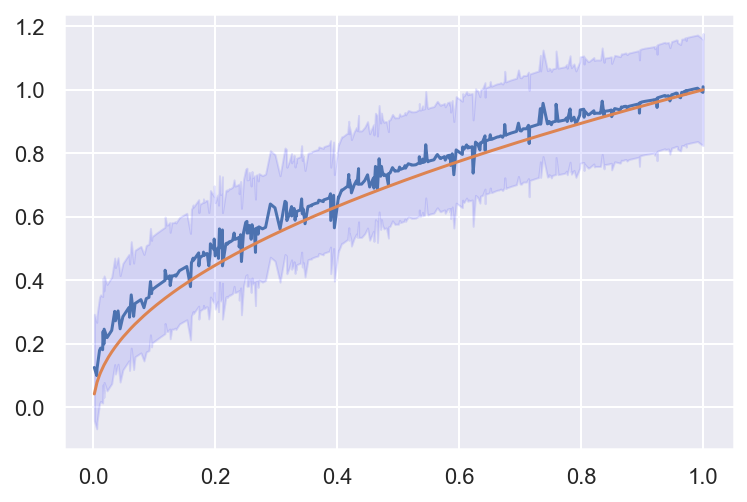

In [272]:
fig, ax = plt.subplots() 
ax.plot(train_x.data, f_pred.data)
ax.fill_between(train_x.data, 
                 f_pred.data + 1 * f_std.data, 
                 f_pred.data - 1 * f_std.data,
                 color='blue', alpha=0.1)
ax.plot(train_x.data, u_model(train_x, theta_u).data)

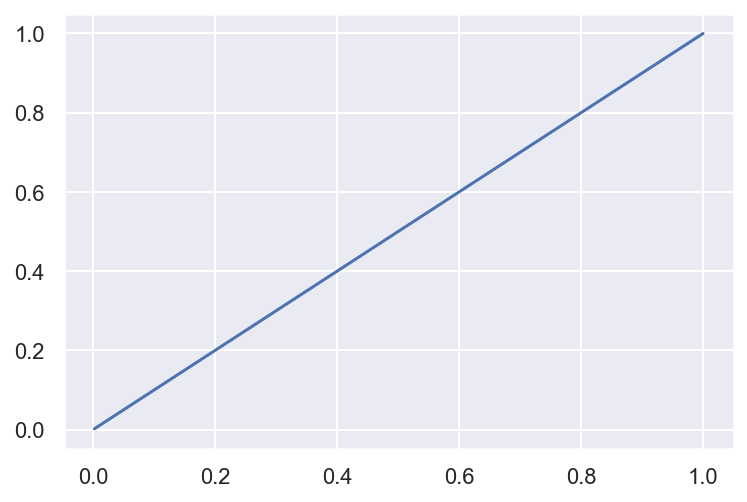

In [33]:
x_ = train_x.data.numpy()
y_ = train_x**0.5 * train_x.T**0.5
y_ = y_.data.numpy()
plt.plot(x_, y_)

# Sparse

In [273]:
class DiscrepancySparse(torch.nn.Module):
    
    def __init__(self, inducing_points, jitter=1e-02, theta=0.5):
        
        super().__init__()
        
        # np.log(np.exp(x) - 1)
        
        self.unc_var = torch.nn.Parameter(torch.zeros(1))
        self.unc_length = torch.nn.Parameter(torch.zeros(1))
        self.eta = torch.nn.Parameter(torch.zeros(inducing_points.size(0)))
        
        self.jitter = jitter
        self.theta = theta
        
        self.softplus = torch.nn.Softplus()
        
        self.inducing_points = inducing_points
        
    def mean_f(self, x):
        return x**self.theta
    
    def var(self):
        return self.softplus(self.unc_var)
    
    def length(self):
        return self.softplus(self.unc_length)
    
    def loss(self, x, y, p, tau, init_order):
        
        est_u, var, length, eta = self(x, return_sd=False)
        
        est_eu_sorted =  p * est_u   
        est_eu = est_eu_sorted[init_order]
        est_diff_eu = est_eu[y.size(0):] - est_eu[:y.size(0)]
        
        logits = tau *est_diff_eu

        nll = - dist.Bernoulli(logits=logits).log_prob(y).sum()
        nlp_eta = - dist.Normal(loc=0, scale=1).log_prob(eta).sum()
        nlp_var =  - TruncatedNormal(loc=0, scale=1, a=0, b=np.inf).log_prob(var).sum()
        nlp_length =  - TruncatedNormal(loc=1, scale=1, a=0, b=np.inf).log_prob(length).sum()
        return  nll + nlp_eta + nlp_var + nlp_length
    
    def forward(self, x, return_sd=True):
        
        var = self.var()
        length = self.length()
        
        eta = self.eta
        
        x_ind = self.inducing_points
        x_pred = x
        
        K = var**2 * kernel(x_ind, x_ind, length) + self.jitter * torch.eye(x_ind.size(0))
        L = torch.linalg.cholesky(K)
        
#         K_xp = var**2 * kernel(x_ind, x_pred, length)
#         L_eta = L@eta
#         L_eta_2D = L_eta.reshape(-1, 1)
        
#         A, _ = torch.triangular_solve(K_xp, L, upper=False)
#         v, _ = torch.triangular_solve(L_eta_2D, L, upper=False)
        
#         m_p = self.mean_f(x_pred)
#         v_1D = v.squeeze(-1)

#         f_pred = m_p + A.T@v_1D
        
        f = self.mean_f(x_ind) + L@eta
        alpha = torch.cholesky_solve(f.reshape(-1, 1), L, upper=False)
        alpha = alpha.squeeze(-1)
        
        K_px = var**2 * kernel(x_pred, x_ind, length)
        f_pred = K_px@alpha

        if return_sd:
            A, _ = torch.triangular_solve(K_px.T, L, upper=False)
            
            K_pp = var**2 * kernel(x_pred, x_pred, length)
            cov_predict = K_pp - A.T@A
            f_var = torch.diag(cov_predict)
            f_sd = torch.sqrt(f_var)
            return f_pred, f_sd
        else:
            return f_pred, var, length, eta
    

# Run

In [274]:
u_model = u_pow
theta_u = 0.5
tau = 33.33
data = generate_data(u=u_model, n=200, tau=tau, theta=(theta_u, ))
data

,p0,x0,p1,x1,choices
308,0.710046,0.972624,0.916240,0.971488,1
771,0.254806,0.549418,0.933566,0.436220,1
1168,0.846783,0.135510,0.504619,0.547520,1
977,0.800907,0.270393,0.591541,0.534649,1
852,0.832668,0.260333,0.366150,0.920683,0
...,...,...,...,...,...
1322,0.834019,0.068404,0.111335,0.536288,0
824,0.012429,0.509863,0.981862,0.232335,1
1028,0.018290,0.849445,0.396082,0.844821,1
1246,0.338320,0.925665,0.968984,0.663299,1


In [275]:
# tau_hat, theta_hat = optimize(data, u_m=u_pow)
# print("tau_hat", tau_hat, "theta_hat", theta_hat)

In [276]:
p0 = data.p0.values
p1 = data.p1.values
x0 = data.x0.values
x1 = data.x1.values
y = data.choices.values

x = np.hstack((x0, x1))
p = np.hstack((p0, p1))

x_order = np.argsort(x)
x_sorted = x[x_order]
p_sorted = p[x_order]
init_order = np.argsort(x_order)

n_x = len(x_sorted)
n_y = len(y)
print(n_x)

400


In [277]:
train_x = torch.from_numpy(x_sorted.astype(np.float32))
train_y = torch.from_numpy(y.astype(np.float32))
train_p = torch.from_numpy(p_sorted.astype(np.float32))
TAU = tau
U_MODEL = u_model
THETA = theta_u

In [278]:
model = DiscrepancySparse(inducing_points=torch.linspace(0, 1, 100), theta=theta_u, jitter=1e-04)

epochs = 1000 

optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

iterator = tqdm(range(epochs))

for i in iterator:
    
    optimizer.zero_grad()
    loss = model.loss(train_x, train_y, tau=TAU, p=train_p, init_order=init_order)
    loss.backward()
    
    optimizer.step()
    
    iterator.set_postfix(loss=loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

In [279]:
f_pred, f_std = model(train_x)

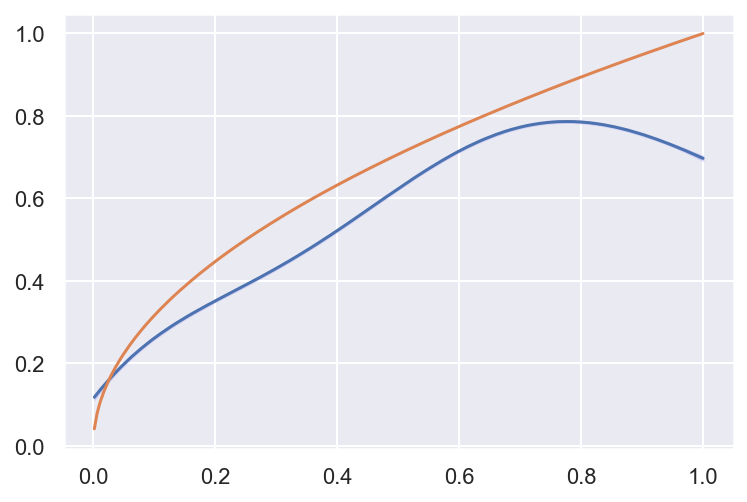

In [280]:
fig, ax = plt.subplots() 
ax.plot(train_x.data, f_pred.data)
ax.fill_between(train_x.data, 
                 f_pred.data + 1 * f_std.data, 
                 f_pred.data - 1 * f_std.data,
                 color='blue', alpha=0.1) 
ax.plot(train_x.data, u_model(train_x, theta_u).data)

In [298]:
x_ind = torch.linspace(0, 1, 20)
eta = torch.randn(20)
x_pred = torch.linspace(0, 1, 30)
var = 1
length = 1 

In [299]:
K = var**2 * kernel(x_ind, x_ind, length) + 1e-06 * torch.eye(x_ind.size(0))
L = torch.linalg.cholesky(K)

In [312]:
eta = torch.randn(torch.Size((20, 10)))

In [313]:
L_eta = L@eta

In [314]:
L_eta.shape

torch.Size([20, 10])

In [291]:
def mean_f(x):
    return torch.zeros(x.size(0))

In [292]:
K_xp = var**2 * kernel(x_ind, x_pred, length)
L_eta = L@eta
L_eta_2D = L_eta.reshape(-1, 1)

A, _ = torch.triangular_solve(K_xp, L, upper=False)
v, _ = torch.triangular_solve(L_eta_2D, L, upper=False)

m_p = mean_f(x_pred)
v_1D = v.squeeze(-1)

f_pred = m_p + A.T@v_1D
f_pred.data[:10]

tensor([-1.2397, -1.2462, -1.2509, -1.2537, -1.2552, -1.2554, -1.2537, -1.2509,
        -1.2464, -1.2405])

In [293]:
m_x = mean_f(x_ind)
f = m_x + L@eta
alpha = torch.cholesky_solve(f.reshape(-1, 1), L, upper=False)
alpha = alpha.squeeze(-1)

K_px = var**2 * kernel(x_pred, x_ind, length)
f_pred = K_px@alpha
f_pred.data[:10]

tensor([-1.2397, -1.2461, -1.2510, -1.2544, -1.2559, -1.2554, -1.2539, -1.2510,
        -1.2466, -1.2412])

In [297]:
K_px = var**2 * kernel(x_pred, x_ind, length)
K_inv = torch.linalg.inv(K)
f = mean_f(x_ind) + L@eta
f_pred = K_px@K_inv@f
f_pred.data[:10]

tensor([-1.3708, -1.4214, -1.4042, -1.5340, -1.4359, -1.4941, -1.4056, -1.3810,
        -1.3665, -1.3335])